In [0]:
import imageio
import cv2
import numpy as np
import os
import pickle
import re
import PIL
from PIL import Image

## Challenge Categories

In [0]:
CATEGORIES = [
    "boxing",
    "handclapping",
    "handwaving",
    "jogging",
    "running",
    "walking"
]

IMG_W = 60
IMG_H = 80
CHANNELS = 1
INPUT_SHAPE = (IMG_W, IMG_H, CHANNELS)
NCLASSES = 6

EPOCHS = 25
BATCH_SIZE = 64

### Spliting Dataset

In [0]:
# Dataset are divided according to the instruction at:
# http://www.nada.kth.se/cvap/actions/00sequences.txt
TRAIN_PEOPLE_ID = [11, 12, 13, 14, 15, 16, 17, 18]
DEV_PEOPLE_ID = [19, 20, 21, 23, 24, 25, 1, 4]
TEST_PEOPLE_ID = [22, 2, 3, 5, 6, 7, 8, 9, 10]

## Loading Dataset

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
print("Loading dataset ..")
train_videos = pickle.load(open("/content/drive/My Drive/DATASETS/KTH/Dataset pickles/train.p", "rb"))
dev_videos = pickle.load(open("/content/drive/My Drive/DATASETS/KTH/Dataset pickles/dev.p", "rb"))
test_videos = pickle.load(open("/content/drive/My Drive/DATASETS/KTH/Dataset pickles/test.p", "rb"))

Loading dataset ..


##Preparing dataset

In [0]:
def read_ds(ds="train"):
  if(ds == "dev"):
    videos = dev_videos
  elif (ds == "test"):
    videos = test_videos
  else:
    videos = train_videos
      
  X = []
  y = []
  for video in videos:
      for frame in video["frames"]:
          X.append(frame.reshape(INPUT_SHAPE))
          y.append(CATEGORIES.index(video["category"]))

  X = np.array(X, dtype=np.float32)
  y = np.array(y, dtype=np.uint8)

  '''
  mean = np.mean(X)
  X -= float(mean)
  '''
  return X, y

In [0]:
X_train, y_train = read_ds(ds="train")
X_dev, y_dev = read_ds(ds="dev")
X_test, y_test = read_ds(ds="test")

In [0]:
X_train[0].shape

(60, 80, 1)

In [0]:
X_train.shape

(74672, 60, 80, 1)

In [0]:
np.unique(y_train)

array([0, 1, 2, 3, 4, 5], dtype=uint8)

In [0]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Input, ZeroPadding2D, Conv2D, MaxPooling2D, Activation, add
from keras.utils import to_categorical
from keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

import tensorflow.keras
from tensorflow.keras.layers import Conv2D, Dropout, MaxPool2D, AvgPool2D, Add, Dense 
from tensorflow.keras.preprocessing.image import load_img, img_to_array


from keras.models import Model

from keras.utils import plot_model

import warnings
#warnings.warn("ignore")
import os

Using TensorFlow backend.


In [0]:
def inception_module(layer_in, f1, f2_in, f2_out, f3_in, f3_out, f4_out):
  # 1x1 conv
  conv1 = Conv2D(f1, (1,1), padding='same', activation='relu')(layer_in)
  # 3x3 conv
  conv3 = Conv2D(f2_in, (1,1), padding='same', activation='relu')(layer_in)
  conv3 = Conv2D(f2_out, (3,3), padding='same', activation='relu')(conv3)
  # 5x5 conv
  conv5 = Conv2D(f3_in, (1,1), padding='same', activation='relu')(layer_in)
  conv5 = Conv2D(f3_out, (5,5), padding='same', activation='relu')(conv5)
  # 3x3 max pooling
  pool = MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_in)
  pool = Conv2D(f4_out, (1,1), padding='same', activation='relu')(pool)
  # concatenate filters, assumes filters/channels last
  layer_out = concatenate([conv1, conv3, conv5, pool], axis=-1)
  return layer_out


In [0]:
def identity_block(X, f, filters, stage, block):
  # defining name basis
  conv_name_base = 'res' + str(stage) + block + '_branch'
  bn_name_base = 'bn' + str(stage) + block + '_branch'

  # Retrieve Filters
  F1, F2, F3 = filters

  # Save the input value. We'll need this later to add back to the main path. 
  X_shortcut = X

  # First component of main path
  X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
  X = Activation('relu')(X)

  # Second component of main path
  X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
  X = Activation('relu')(X)

  # Third component of main path
  X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

  # Final step: Add shortcut value to main path, and pass it through a RELU activation
  X = Add()([X, X_shortcut])
  X = Activation('relu')(X)

  return X

In [0]:
def convolutional_block(X, f, filters, stage, block, s = 2):
  # defining name basis
  conv_name_base = 'res' + str(stage) + block + '_branch'
  bn_name_base = 'bn' + str(stage) + block + '_branch'
  
  # Retrieve Filters
  F1, F2, F3 = filters
  
  # Save the input value
  X_shortcut = X
  

  ##### MAIN PATH #####
  # First component of main path 
  X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
  X = Activation('relu')(X)

  # Second component of main path
  X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
  X = Activation('relu')(X)

  # Third component of main path
  X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

  
  ##### SHORTCUT PATH ####
  X_shortcut = Conv2D(F3, (1, 1), strides = (s,s), name = conv_name_base + '1', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
  X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

  # Final step: Add shortcut value to main path, and pass it through a RELU activation
  X = Add()([X, X_shortcut])
  X = Activation('relu')(X)
  
  return X

In [0]:
def DeepResNetInception(input_shape = (150, 150, 3), classes = 6):   
  # Define the input as a tensor with shape input_shape
  X_input = Input(input_shape)

  
  # Zero-Padding
  #X = ZeroPadding2D((3, 3))(X_input)
  X = X_input
  
  # Stage 1
  X = Conv2D(16, (3, 3), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
  X = Activation('relu')(X)

  # Stage 2
  X = Conv2D(32, (3, 3), strides = (2, 2), name = 'conv2', kernel_initializer = glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis = 3, name = 'bn_conv2')(X)
  X = Activation('relu')(X)

    
  # Stage 3
  X = Conv2D(64, (3, 3), strides = (2, 2), name = 'conv3', kernel_initializer = glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis = 3, name = 'bn_conv3')(X)
  X = Activation('relu')(X)
      

  # inception module (out 128)
  X = inception_module(X, f1=32, f2_in=(32+8), f2_out=64, f3_in=8, f3_out=16, f4_out=16)
  X = BatchNormalization(axis = 3, name = 'bn_conv4')(X)
  X = Activation('relu')(X)    

  # Stage 5
  X = convolutional_block(X, f = 3, filters = [128, 128, 256], stage = 4, block='a', s = 2)
  X = identity_block(X, 3, [128, 128, 256], stage=4, block='b')
  X = BatchNormalization(axis = 3, name = 'bn_conv5')(X)
  X = Activation('relu')(X)    
  
  # AVGPOOL
  X = AveragePooling2D((2, 2), name='avg_pool')(X)

  # output layer
  X = Flatten()(X)
  #X = Dropout(0.25)(X)
  X = Dense(classes, activation='softmax', name='fc' + str(classes),  kernel_initializer = glorot_uniform(seed=0))(X)
  
  # Create model
  model = Model(inputs = X_input, outputs = X, name='DeepRes-ception')

  return model

In [0]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import cv2
import numpy as np
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D
from keras.models import Model, load_model
from keras.initializers import glorot_uniform
from keras.utils import plot_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import keras.backend as K
import tensorflow as tf

from keras.layers.merge import concatenate

In [0]:
model = DeepResNetInception(input_shape=INPUT_SHAPE, classes=6)

In [0]:
model.summary()

Model: "DeepRes-ception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 60, 80, 1)    0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 29, 39, 16)   160         input_1[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 29, 39, 16)   64          conv1[0][0]                      
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 29, 39, 16)   0           bn_conv1[0][0]                   
____________________________________________________________________________________

In [0]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
from keras.utils import to_categorical
y_train = to_categorical(y_train)
y_dev = to_categorical(y_dev)
y_test = to_categorical(y_test)

In [0]:
trained_model = model.fit(X_train, y_train, epochs = EPOCHS, batch_size = BATCH_SIZE, validation_data=(X_dev, y_dev) , shuffle=True)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 74672 samples, validate on 72821 samples
Epoch 1/25
74672/74672 [==============================] - 72s 966us/step - loss: 0.3993 - acc: 0.8377 - val_loss: 2.1799 - val_acc: 0.4070
Epoch 2/25
74672/74672 [==============================] - 65s 868us/step - loss: 0.1383 - acc: 0.9465 - val_loss: 2.9895 - val_acc: 0.3326
Epoch 3/25
74672/74672 [==============================] - 64s 852us/step - loss: 0.0865 - acc: 0.9674 - val_loss: 2.1765 - val_acc: 0.4025
Epoch 4/25
74672/74672 [==============================] - 64s 855us/step - loss: 0.0631 - acc: 0.9773 - val_loss: 3.0351 - val_acc: 0.3471
Epoch 5/25
74672/74672 [==============================] - 65s 864us/step - loss: 0.0489 - acc: 0.9833 - val_loss: 3.1154 - val_acc: 0.3905
Epoch 6/25
74672/74672 [==============================] - 66s 880us/step - loss: 0.0417 - acc: 0.9856 - val_loss: 3.3421 - val_acc: 0.3972
Epoch 7/25
74672/746

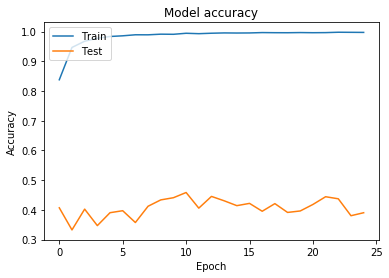

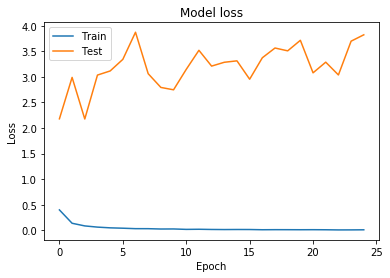

In [0]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(trained_model.history['acc'])
plt.plot(trained_model.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy') 
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(trained_model.history['loss'])
plt.plot(trained_model.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [0]:
model.evaluate(X_test, y_test)

79266/79266 [==============================] - 18s 223us/step


[4.26595516505367, 0.3798602174955214]

In [0]:
model.save_weights('Deep-Res-ception_KTH.h5')

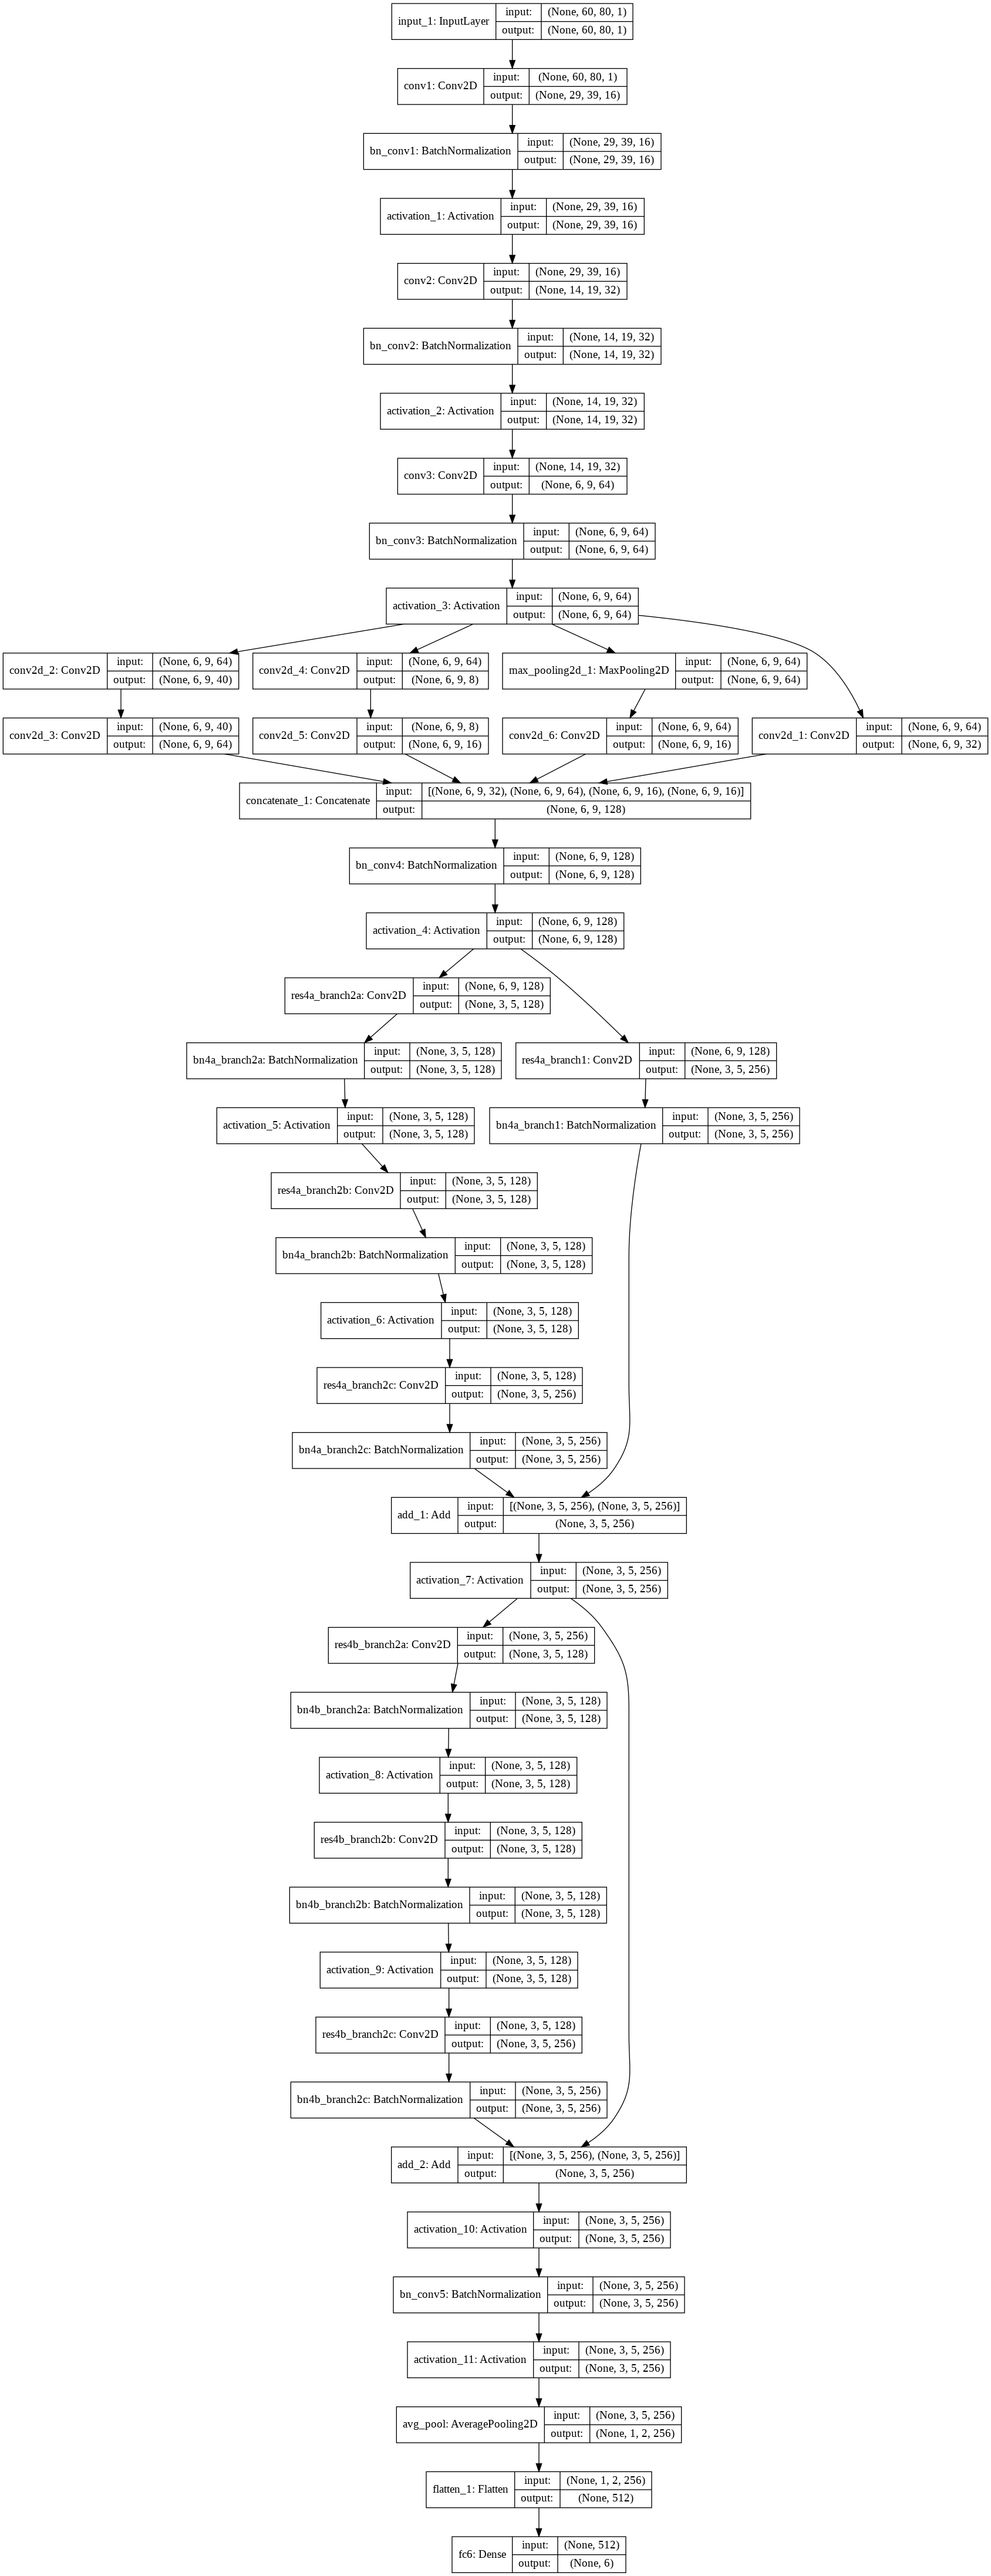

In [0]:
plot_model(model, show_shapes=True, to_file='Deep-Res-Inception.png')